# <center> EMVA
# <center> Prepared by Denver Lloyd
# <center>8/18/2021

In [39]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import fivecentplots as fcp
from characterization_ams.stats_engine import stats
from characterization_ams.emva import emva
from characterization_ams.unittests import image_generator
import pdb
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Generate Images

#### PTC Dataset Generation

In [41]:
pedestal=168
ped_start = 168
peds = np.linspace(pedestal, 3800, 30)
power = np.linspace(0, 10, 30)
rows=100
cols=100
n_images=30
images = []
temp = pd.DataFrame()
raw = pd.DataFrame()
for (idx, pp) in enumerate(peds):
    n_images=1000
    rfpn=105
    cfpn=101
    ctn = 15
    rtn = 12
    ptn = 20 + np.sqrt(pp)
    pfpn= 95 + 0.08 * (pp - ped_start)

    tot_t = np.sqrt(ctn**2 + rtn**2 + ptn**2)
    tot_f = np.sqrt(rfpn**2 + pfpn**2 + cfpn**2)

    # fpn
    imgs = image_generator.gen_images(cfpn=cfpn,
                                      rfpn=rfpn,
                                      pfpn=pfpn,
                                      rtn=rtn,
                                      ptn=ptn,
                                      ctn=ctn,
                                      rows=rows,
                                      cols=cols,
                                      pedestal=pp,
                                      n_images=n_images)

    images.append(imgs)

    temp['Power'] = pd.Series(power[idx])
    temp['imageid'] = idx
    temp['stack size'] = n_images
    temp['rows'] = rows
    temp['cols'] = cols
    raw = pd.concat([raw, temp]).reset_index(drop=True)

### Get Noise Metrics

- This section utilizes the stats engine to get all noise metrics of interest from each image stack. All calculations meet the emva1288 4.0 standard
    - **source:** https://forge.ams.com/ctf/code/projects.jupy/git/scm.characterization/file/source/stats_engine/stats.py?treeId=refs%2Fheads%2Fmaster
    - **notebook:** https://forge.ams.com/ctf/code/projects.jupy/git/scm.characterization/file/notebooks/stats_engine/Test_Stats.ipynb?treeId=refs%2Fheads%2Fmaster

In [42]:
temp = pd.DataFrame()
data = pd.DataFrame()
groups = raw.groupby(['imageid'])

for idx, (nn, gg) in enumerate(groups):
    
    # get images
    img_stack = images[idx]
    
    # calculate all key metrics
    noise_metrics = stats.noise_metrics_all(img_stack)
    
    temp = pd.Series(noise_metrics).to_frame().T
    
    # get other columns of interst for grouping (fake here)
    #pdb.set_trace()
    for cc in gg.columns:
        temp[cc] = gg[cc].unique()[0]
    
    # add to data df
    data = pd.concat([data, temp]).reset_index(drop=True)

In [43]:
data.head()

,tot_var_temp,col_var_temp,row_var_temp,pix_var_temp,tot_var,col_var,row_var,pix_var,mean,Power,imageid,stack size,rows,cols
0,1454.894917,226.851155,145.014999,1083.028762,29082.558790,10093.981809,10166.874663,8821.702318,183.559079,0.000000,0,1000,100,100
1,1747.678069,226.252982,147.312141,1374.112946,31080.436967,10139.301183,10162.897502,10778.238282,308.846706,0.344828,1,1000,100,100
2,2006.406664,226.250118,147.241525,1632.915021,33235.719008,10157.787127,10139.818181,12938.113700,434.248788,0.689655,2,1000,100,100
3,2244.792304,224.962318,146.548426,1873.281560,35594.024918,10171.445215,10135.364144,15287.215559,559.401572,1.034483,3,1000,100,100
4,2470.613513,225.695309,145.899199,2099.019005,38142.734390,10193.795801,10122.507427,17826.431162,684.756813,1.379310,4,1000,100,100


#### Remove black level

In [44]:
data1 = pd.DataFrame()

# get columns of interest (only noise metrics)
cols_ = [c for c in list(data.columns) if c not in ['Power','imageid','stack size', 'rows', 'cols']]

# remove black level
data1 = data[cols_] - data[cols_].iloc[0]

# rename subtracted columns
for cc in data1.columns:
    #pdb.set_trace()
    data1.rename(columns={cc:f'{cc} - dark_{cc}'}, inplace=True)

# add back to original dataset
data = data.join(data1, lsuffix='', rsuffix='')

tint = 16 # ms
data['Exposure [uW/cm^2*s]'] = data['Power'] * tint * 1e-3

### EMVA Functions

In [45]:
summ = pd.DataFrame()
emva_data = pd.DataFrame()
emva_hist = pd.DataFrame()
emva_data['Total Temp Noise - Total Dark Temp Noise [DN^2]'] = data['tot_var_temp - dark_tot_var_temp']
emva_data['Signal - Dark [DN]'] = data['mean - dark_mean']

#### System Gain

~~~ python
"""
calculate system gain [DN/e]
EMVA 4.0: Eq. 15

Keyword Arguments:
    u_y (np.array): signal - dark values (u_y - u_ydark)
    sig2_y (np.array): total temp noise - total dark temp noise
                       (sig2_y - sig2_ydark)

Returns:
    temp (dict): system gain [DN/e]
                 offset
                 std_error
                 fit
"""
~~~

##### Calc

In [46]:
# calculate 
sys_gain = emva.system_gain(u_y=data['mean - dark_mean'],
                            sig2_y=data['tot_var_temp - dark_tot_var_temp'])

# add to emv_data
emva_data['System Gain Fit [DN^2]'] = sys_gain['fit']
summ['System Gain [DN/e]'] = pd.Series(sys_gain['system_gain'])

sys_gain.keys()

dict_keys(['system_gain', 'offset', 'std_error', 'fit'])

##### Assert

In [47]:
print(f'System Gain [DN/e] = {round(sys_gain["system_gain"],1)}')
assert round(sys_gain["system_gain"],1) == 1.6

System Gain [DN/e] = 1.6


#### Plot

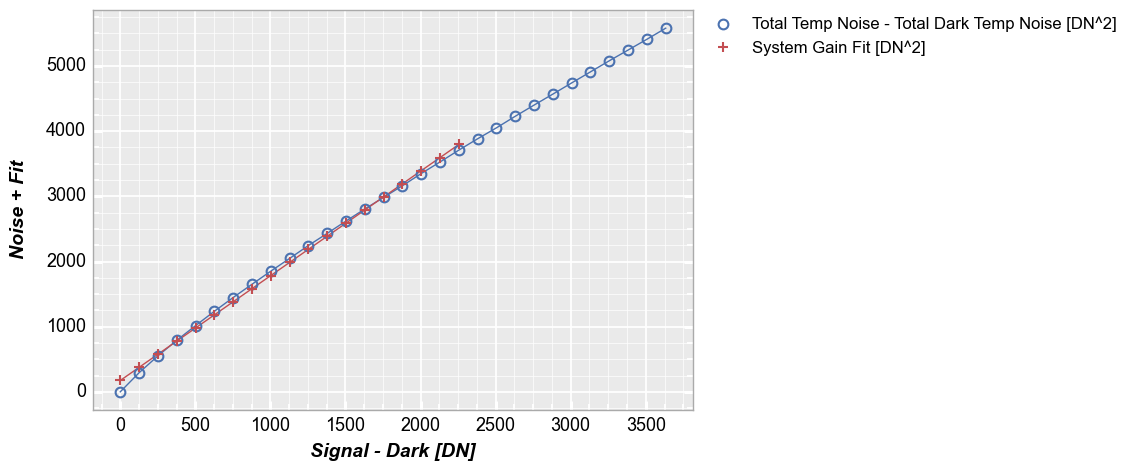

In [48]:
fcp.plot(df=emva_data, x='Signal - Dark [DN]', y=['Total Temp Noise - Total Dark Temp Noise [DN^2]','System Gain Fit [DN^2]'],
         ax_size=[600,400], grid_minor=True, label_y='Noise + Fit')

In [ ]:
emva_data[['Total Temp Noise - Total Dark Temp Noise [DN^2]','System Gain Fit [DN^2]']]

#### Get Photons

~~~ python
"""
calculate the number of photons, can sweep exposure
or power

Keyword Arguments:
    wl (float): wavelength of spectrum used in [nm]
    texp (float|np.array): integration time used in [ms]
    power (float:np.array): power used in [uW/cm^2]
    pixel_area (float): pixel active area in [um]

Returns:
    temp (dict): u_p: number of photons
"""
~~~

##### Calc

In [75]:
wl = 550 # nm
texp = 16 # ms
power = data['Power'] # power at sensor surface
pixel_area = 0.95 * 0.95 # um^2
photons = {}
photons = emva.get_photons(wl=wl,
                           texp=texp,
                           power=power,
                           pixel_area=pixel_area)

# add to emv_data
emva_data['Irradiation [Photons/Pixel]'] = photons['u_p']

photons.keys()

dict_keys(['u_p'])

##### Assert

In [76]:
print(f'Max Irradiation [Photons/Pixel] = {round(photons["u_p"].iloc[-1],0)}')
assert round(photons["u_p"].iloc[-1],0) == 4006

Max Irradiation [Photons/Pixel] = 4006.0


#### Plot

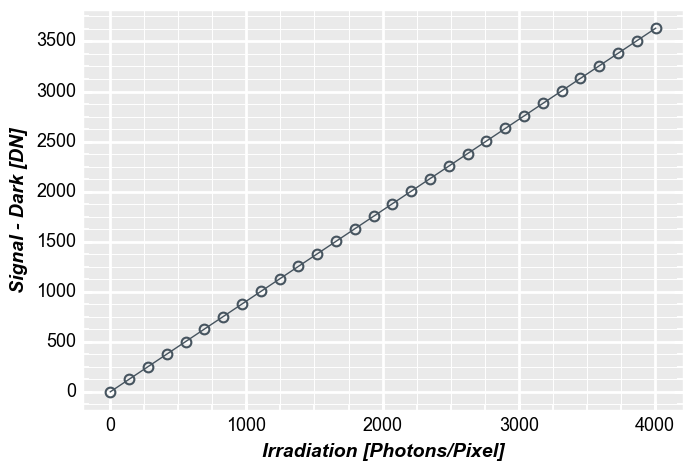

In [77]:
fcp.plot(df=emva_data, y='Signal - Dark [DN]', x=['Irradiation [Photons/Pixel]'],
         ax_size=[600,400], grid_minor=True)

#### Dark Temporal Noise

~~~ python
"""
calculate dark temporal noise
Emva 4.0: Eq. 53

Keyword Arguments:
    sig2_ydark (float): total temporal noise at dark
    K (float): system gain [DN/e]
    s2_q (float, 1/12): quantization noise

Returns:
    temp (dict): dark_temporal_noise_DN
                 dark_temporal_noise_e
"""
~~~

##### Calc

In [78]:
dtn = emva.dark_temporal_noise(sig2_ydark=data['tot_var_temp'].iloc[0],
                               K=summ['System Gain [DN/e]'])

summ['Dark Noise [e]'] = dtn['dark_temporal_noise_e']
summ['Dark Noise [DN]'] = dtn['dark_temporal_noise_DN']

dtn.keys()

dict_keys(['dark_temporal_noise_DN', 'dark_temporal_noise_e'])

##### Assert

In [79]:
print(f'Dark Noise [e] = {round(dtn["dark_temporal_noise_e"][0],1)}')
#assert round(dtn['dark_temporal_noise_e'][0],1) == 23.7

Dark Noise [e] = 23.8


#### DSNU1288

~~~ python
"""
Calculate row, col, pix, and total DSNU1288
EMVA 4.0: Eq. 66

Keyword Arguments:
    dark_img (np.array): array of mean pixel values at black level
    ttn_var (float): temporal noise variance at dark
    L (int): size of imae stack used to calculate dark_img

Returns:
    temp (dict): total_dsnu
                 row_dsnu
                 col_dsnu
                 pix_dsnu
"""
~~~

##### Calc

In [80]:
# required inputs
ttn_var = data['tot_var_temp'].iloc[0]
dark_img = stats.avg_img_stack(images[0])
L = n_images

# calculate 
dsnu = emva.dsnu1288(dark_img=dark_img,
                     ttn_var=ttn_var,
                     L=L)

# add to summ
summ['Total DSNU1288 [DN]'] = dsnu['total_dsnu']
summ['Row DSNU1288 [DN]'] = dsnu['row_dsnu']
summ['Col DSNU1288 [DN]'] = dsnu['col_dsnu']
summ['Pix DSNU1288 [DN]'] = dsnu['pix_dsnu']

dsnu.keys()

dict_keys(['total_dsnu', 'row_dsnu', 'col_dsnu', 'pix_dsnu'])

##### Assert

In [83]:
assert round(dsnu['total_dsnu'], 0) == 162
assert round(dsnu['row_dsnu'], 0) == 94
assert round(dsnu['col_dsnu'], 0) == 91
assert round(dsnu['pix_dsnu'], 0) == 97

##### Plot

In [84]:
summ[['Total DSNU1288 [DN]','Row DSNU1288 [DN]','Col DSNU1288 [DN]', 'Pix DSNU1288 [DN]']]

,Total DSNU1288 [DN],Row DSNU1288 [DN],Col DSNU1288 [DN],Pix DSNU1288 [DN]
0,162.023678,93.732355,90.539284,96.784077


#### DSNU1288 Stack

~~~ python
"""
Calculate DSNU1288 from a stack of images
EMVA 4.0: Eq. 66

Keyword Arguments:
    dark_img (np.array): stack of images

Returns:
    temp (dict): total_dsnu
                 row_dsnu
                 col_dsnu
                 pix_dsnu
"""
~~~

##### Calc

In [85]:
# required inputs
dark_imgs = images[0]

# calculate dsnu1288
dsnu = emva.dsnu1288_stack(img_stack=dark_imgs)

# add to summ
summ['Total DSNU1288 [DN]'] = dsnu['total_dsnu']
summ['Row DSNU1288 [DN]'] = dsnu['row_dsnu']
summ['Col DSNU1288 [DN]'] = dsnu['col_dsnu']
summ['Pix DSNU1288 [DN]'] = dsnu['pix_dsnu']


dsnu.keys()

dict_keys(['total_dsnu', 'row_dsnu', 'col_dsnu', 'pix_dsnu'])

##### Assert

In [87]:
assert round(dsnu['total_dsnu'], 0) == 162
assert round(dsnu['row_dsnu'], 0) == 94
assert round(dsnu['col_dsnu'], 0) == 91
assert round(dsnu['pix_dsnu'], 0) == 97

##### Plot

In [88]:
summ[['Total DSNU1288 [DN]','Row DSNU1288 [DN]','Col DSNU1288 [DN]', 'Pix DSNU1288 [DN]']]

,Total DSNU1288 [DN],Row DSNU1288 [DN],Col DSNU1288 [DN],Pix DSNU1288 [DN]
0,162.023678,93.732355,90.539284,96.784077


#### Dynamic Range

~~~ python
"""
calculate dynamic range
EMVA 4.0: Eq 28

Keyword Arguments:
    u_p (np.array): array of photon values
    sig2_y (np.array): array of total temporal noise, sig2_y - sig2_ydark
    sig2_ydark (float): total temporal noise at dark
    qe (float): quantum efficiency at wavelength used for dataset
    K (float): system gain [DN/e]
    s2_q (float): quantization noise

Returns:
    temp (dict): Dynamic Range [ratio]
                 Dynamic Range [dB]
                 Dynamic Range [bits]
"""
~~~

##### Calc

In [89]:
# required inputs
u_p = emva_data['Irradiation [Photons/Pixel]']
sig2_y = data['tot_var_temp - dark_tot_var_temp']
sig2_ydark = data['tot_var_temp'].iloc[0]
qe = 0.9
K = summ['System Gain [DN/e]'].unique()[0]

# calculate 
dr = emva.dynamic_range(u_p=u_p,
                        sig2_y=sig2_y,
                        sig2_ydark=sig2_ydark,
                        qe=qe,
                        K=K)

# add to summ"
summ['Dynamic Range [ratio]'] = dr['dynamic_range_ratio']
summ['Dynamic Range [dB]'] = dr['dynamic_range_db']
summ['Dynamic Range [bits]'] = dr['dynamic_range_bits']

dr.keys()

dict_keys(['dynamic_range_ratio', 'dynamic_range_db', 'dynamic_range_bits'])

##### Assert

In [90]:
round(dr['dynamic_range_ratio'],0)

143.0

In [91]:
#assert round(dr['dynamic_range_ratio'],0) == 144
print(f'Dynamic Range [ratio] = {round(dr["dynamic_range_ratio"],1)}')
print(f'Dynamic Range [dB] = {round(dr["dynamic_range_db"],1)}')
print(f'Dynamic Range [bits] = {round(dr["dynamic_range_bits"],1)}')

Dynamic Range [ratio] = 143.5
Dynamic Range [dB] = 43.1
Dynamic Range [bits] = 7.2


##### Plot

In [92]:
summ[['Dynamic Range [ratio]','Dynamic Range [dB]','Dynamic Range [bits]']]

,Dynamic Range [ratio],Dynamic Range [dB],Dynamic Range [bits]
0,143.486795,43.136239,7.164774


#### Get Electrons

~~~ python
"""
calculate the number of electrons based on DN signal

Keyword Arguments:
    u_y (np.array): mean signal in DN
    K (float): system gain [DN/e]

Returns:
    temp (dict): u_e: number of electrons
"""
~~~

##### Calc

In [93]:
# required inputs
u_y = data['mean - dark_mean']
K = summ['System Gain [DN/e]'].unique()[0]

# calculate 
ele = emva.get_electrons(u_y=u_y,
                         K=K)

# add to summ"
emva_data['Electrons [e]'] = ele['u_e']

ele.keys()

dict_keys(['u_e'])

##### Assert

In [99]:
assert round(np.array(ele['u_e'])[-1],0) == 2261

In [95]:
#assert round(np.array(ele['u_e'])[-1],-1) == 2260
print(f'Electrons [e] = {round(np.array(ele["u_e"])[-1],0)}')

Electrons [e] = 2261.0


#### Histogram1288 (PRNU1288 Example)

~~~ python
"""
calculate histogram bins and values from an image
EMVA 4.0: Section 8.8

Keyword Arguments:
    img (np.array): array of pixel values
    Qmax (int): number of bins (Qmax <= 256)
    L (int): size of image stack
    black_level (bool): If true bins are shifted to be centered around 0
                        this should be True for DSNU1288 histogram where
                        our img != img - dark

Returns:
    temp (dict): values: number of pixels/bin
                 bins: deviation from mean
                 accumulated values: percent of pixels/bin
                 accumulated bins: deviation from mean
"""
~~~

##### Calc

In [100]:
# required inputs
black_img = stats.avg_img_stack(images[0])
light_img = stats.avg_img_stack(images[len(images)//2])
img = light_img - black_img # prnu image
Qmax = 256
L = n_images
black_level = False # not a black level (DSNU) image, so hpf is applied

# calculate 
prnu_hist = emva.histogram1288(img=img,
                               Qmax=Qmax,
                               L=L,
                               black_level=black_level)

# add to summ"
emva_hist['PRNU1288 Bins'] = prnu_hist['prnu_bins']
emva_hist['PRNU1288 Values'] = prnu_hist['prnu_values']
emva_hist['PRNU1288 Model'] = prnu_hist['prnu_model']
emva_hist['PRNU1288 Accumulated Bins'] = pd.Series(prnu_hist['prnu_accumulated_bins'])
emva_hist['PRNU1288 Accumulated Values'] = pd.Series(prnu_hist['prnu_accumulated_values'])
emva_hist['PRNU1288 Accumulated Model'] = pd.Series(prnu_hist['prnu_accumulated_model'])

prnu_hist.keys()

dict_keys(['prnu_bins', 'prnu_values', 'prnu_model', 'prnu_accumulated_bins', 'prnu_accumulated_values', 'prnu_accumulated_model'])

In [101]:
len(images[0])

1000

##### Assert

In [102]:
# round(prnu_hist['values'][100].mean(),0) == 90
print(f'Mean Hist Values = {round(prnu_hist["prnu_values"].mean(),0)}')

Mean Hist Values = 36.0


##### Plot

###### Histogram

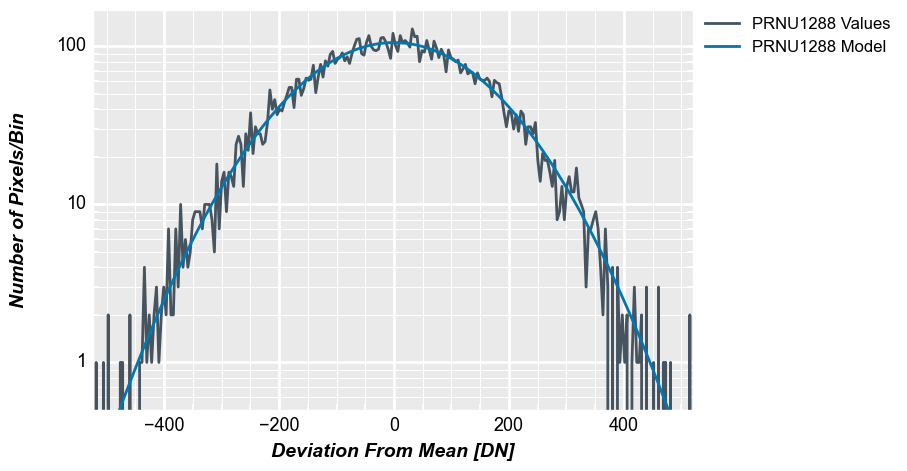

In [103]:
fcp.plot(df=emva_hist, x='PRNU1288 Bins', y=['PRNU1288 Values','PRNU1288 Model'], ax_scale='logy',
         ax_size=[600,400], grid_minor=True, ymin=0.5, label_x='Deviation From Mean [DN]',
         label_y='Number of Pixels/Bin', markers=False, line_width=2)

###### Accumulated Histogram

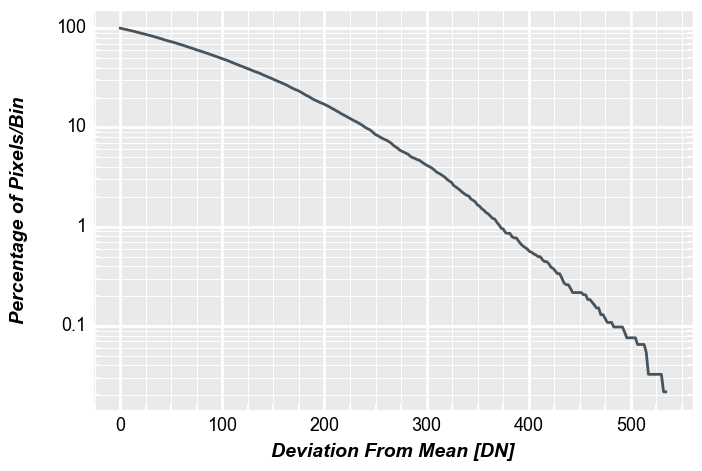

In [104]:
fcp.plot(df=emva_hist, x='PRNU1288 Accumulated Bins', y=['PRNU1288 Accumulated Values'], ax_scale='logy',
         ax_size=[600,400], grid_minor=True, label_x='Deviation From Mean [DN]',
         label_y='Percentage of Pixels/Bin', markers=False, line_width=2)

#### Histogram1288 Stack (DSNU1288 Example)

~~~ python
"""
calculate histogram bins and values from a stack of images
EMVA 4.0: Section 8.8

Keyword Arguments:
    img_stack (np.array): stack of images
    Qmax (int): number of bins (Qmax <= 256)
    black_level (bool): If true bins are shifted to be centered around 0
                        this should be True for DSNU1288 histogram where
                        our img != img - dark
Returns:
    temp (dict): values: number of pixels/bin
                 bins: deviation from mean
                 accumulated values: percent of pixels/bin
                 accumulated bins: deviation from mean
"""
~~~

##### Calc

In [105]:
# required inputs
img_stack = images[0]
Qmax = 256
black_level = True # black level (DSNU) image, so NO hpf is applied

# calculate 
dsnu_hist = emva.histogram1288_stack(img_stack=img_stack,
                                     Qmax=Qmax,
                                     black_level=black_level)

# add to summ"
emva_hist['DSNU1288 Bins'] = pd.Series(dsnu_hist['dsnu_bins'])
emva_hist['DSNU1288 Values'] = pd.Series(dsnu_hist['dsnu_values'])
emva_hist['DSNU1288 Model'] = pd.Series(dsnu_hist['dsnu_model'])
emva_hist['DSNU1288 Accumulated Bins'] = pd.Series(dsnu_hist['dsnu_accumulated_bins'])
emva_hist['DSNU1288 Accumulated Values'] = pd.Series(dsnu_hist['dsnu_accumulated_values'])
emva_hist['DSNU1288 Accumulated Model'] = pd.Series(dsnu_hist['dsnu_accumulated_model'])

dsnu_hist.keys()

dict_keys(['dsnu_bins', 'dsnu_values', 'dsnu_model', 'dsnu_accumulated_bins', 'dsnu_accumulated_values', 'dsnu_accumulated_model'])

##### Assert

In [106]:
#assert round(dsnu_hist['values'][10],0) == 105
print(f'Mean Hist Values = {round(dsnu_hist["dsnu_values"].mean(),0)}')

Mean Hist Values = 45.0


##### Plot

###### Histogram

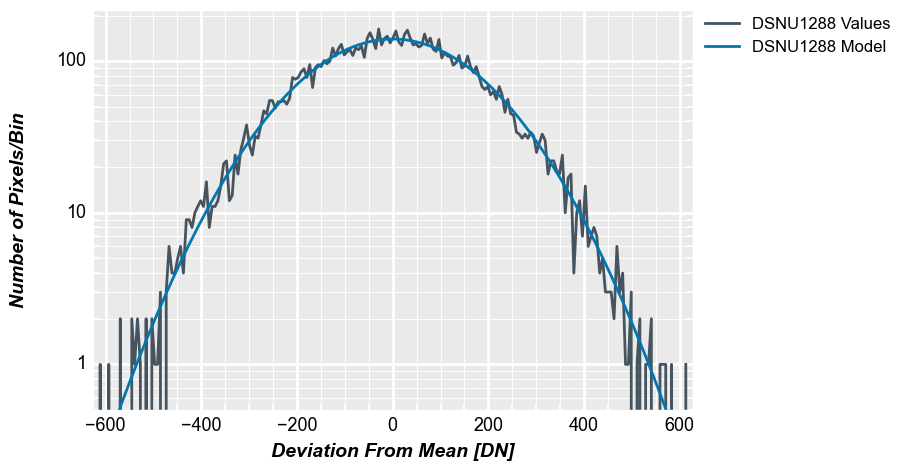

In [107]:
fcp.plot(df=emva_hist, x='DSNU1288 Bins', y=['DSNU1288 Values','DSNU1288 Model'], ax_scale='logy',
         ax_size=[600,400], grid_minor=True, ymin=0.5, label_x='Deviation From Mean [DN]',
         label_y='Number of Pixels/Bin', markers=False, line_width=2)

###### Accumulated Histogram

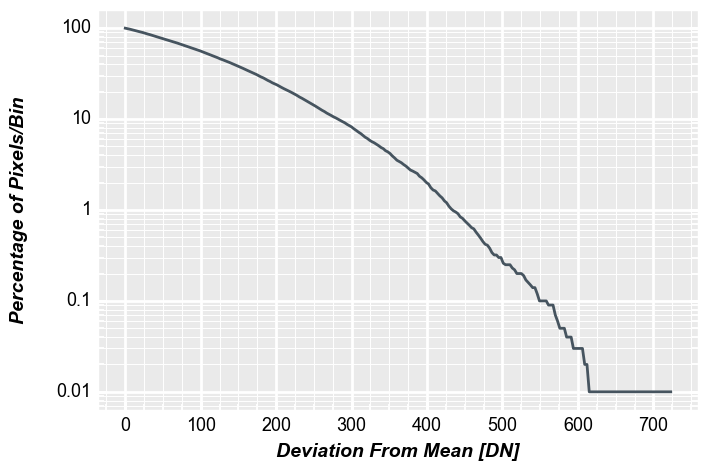

In [108]:
fcp.plot(df=emva_hist, x='DSNU1288 Accumulated Bins', y=['DSNU1288 Accumulated Values'], ax_scale='logy',
         ax_size=[600,400], grid_minor=True, label_x='Deviation From Mean [DN]',
         label_y='Percentage of Pixels/Bin', markers=False, line_width=2)

#### Linearity

~~~ python
"""
calculate weighted linearity error
EMVA 4.0: Eq. 61 & 62

Keyword Arguments:
     mean_arr (np.array): mean signal array used for fit
     exp_arr (np.array): exposure array used for fit
     ttn_arr (np.aray): total temporal noise array

Returns: temp (dict): Linearity Fit
                      Linearity Error
                      Linearity Error [%]
                      Linearity Error max [%]
                      Linearity Error min [%]
                      Linearity Error max
                      Linearity Error min
"""
~~~

##### Calc

In [109]:
# required inputs
mean_arr = data['mean - dark_mean']
exp_arr = data['Exposure [uW/cm^2*s]']
ttn_arr = data['tot_var_temp - dark_tot_var_temp']

# calculate 
lin = emva.linearity(mean_arr=mean_arr,
                     exp_arr=exp_arr,
                     ttn_arr=ttn_arr)

# add to emva_data
emva_data['Exposure [uW/cm^2*s]'] = data['Exposure [uW/cm^2*s]']
emva_data['Linearity Fit [DN]'] = lin['linearity_fit_DN']
emva_data['Linearity Error [%]'] = lin['linearity_error_%']
emva_data['Linearity Error [DN]'] = lin['linearity_error_DN']
summ['Linearity Error Max [%]'] = pd.Series(lin['linearity_error_max_%'])
summ['Linearity Error Max [DN]'] = lin['linearity_error_max_DN']
summ['Linearity Error Min [%]'] = lin['linearity_error_min_%']
summ['Linearity Error Min [DN]'] = lin['linearity_error_min_DN']

lin.keys()

dict_keys(['linearity_fit_DN', 'linearity_error_DN', 'linearity_error_%', 'linearity_error_max_%', 'linearity_error_min_%', 'linearity_error_max_DN', 'linearity_error_min_DN'])

##### Assert

In [110]:
#assert round(lin['linearity_error_DN'].mean(),0) == 0
print(f'Mean Linearity Error = {round(lin["linearity_error_DN"].mean(),0)}')

Mean Linearity Error = 0.0


##### Plot

In [ ]:
summ[['Linearity Error Max [%]','Linearity Error Max [DN]','Linearity Error Min [%]','Linearity Error Min [DN]']]

##### Linearity Fit

In [ ]:
fcp.plot(df=emva_data, x='Exposure [uW/cm^2*s]', y=['Signal - Dark [DN]','Linearity Fit [DN]'],
         ax_size=[600,400], grid_minor=True, markers=False, line_width=2)

###### Linearity Error [%]

In [ ]:
fcp.plot(df=emva_data, x='Exposure [uW/cm^2*s]', y=['Linearity Error [%]'],
         ax_size=[600,400], grid_minor=True, markers=False, line_width=2,
         filter='Linearity Error [%] > -95')

###### Linearity Error [DN]

In [ ]:
fcp.plot(df=emva_data, x='Exposure [uW/cm^2*s]', y=['Linearity Error [DN]'],
         ax_size=[600,400], grid_minor=True, markers=False, line_width=2,
         filter='Linearity Error [%] > -95')

#### PRNU1288

- **Note:** Applying the hpf as specified in the EMVA is making the row/col spatial variance come out negative. Not clear if this is just the dataset generated or will be an issue for all datasets

~~~ python
"""
calculate total, row, col, and pix PRNU1288 from avg images
EMVA 4.0: Eq. 67

Keyword Arguments:
    dark_img (np.array): image of average black level values
    light_img (np.array): image of average signal values at 50% sat.
    light_ttn_var (float): total temporal noise from stack 50% sat.
                           average was taken from
    dark_ttn_var (float): total temporal noise from stack dark
                          average was taken from
    L (float): number of frames in stack average was taken from

Returns:
    temp (dict): Total PRNU1288 [%]
                 Row PRNU1288 [%]
                 Col PRNU1288 [%]
                 Pix PRNU1288 [%]
"""
~~~

##### Calc

In [112]:
# required inputs
dark_img = stats.avg_img_stack(images[0])
light_img = stats.avg_img_stack(images[len(images)//2])
dark_ttn_var = np.mean(stats.tot_var_img_stack(images[0]))
light_ttn_var = np.mean(stats.tot_var_img_stack(images[len(images)//2]))
L = n_images

# calculate
prnu_s = emva.prnu1288(dark_img=dark_img,
                       light_img=light_img,
                       dark_ttn_var=dark_ttn_var,
                       light_ttn_var=light_ttn_var,
                       L=L)

summ['Total PRNU1288 [%]'] = prnu_s['tot_prnu1288_%']
summ['Row PRNU1288 [%]'] = prnu_s['row_prnu1288_%']
summ['Col PRNU1288 [%]'] = prnu_s['col_prnu1288_%']
summ['Pix PRNU1288 [%]'] = prnu_s['pix_prnu1288_%']

prnu_s.keys()

dict_keys(['tot_prnu1288_%', 'row_prnu1288_%', 'col_prnu1288_%', 'pix_prnu1288_%'])

##### Assert

In [115]:
print(f'Total PRNU1288 [%] = {round(prnu_s["tot_prnu1288_%"],0)}')
#assert round(prnu_s['tot_prnu1288_%'],1) == 8.4

Total PRNU1288 [%] = 12.0


##### Plot

In [114]:
summ[['Total PRNU1288 [%]', 'Row PRNU1288 [%]', 'Col PRNU1288 [%]', 'Pix PRNU1288 [%]']]

,Total PRNU1288 [%],Row PRNU1288 [%],Col PRNU1288 [%],Pix PRNU1288 [%]
0,12.189044,NaN,0.725605,12.257505


#### PRNU1288 Stack

- **Note:** Applying the hpf as specified in the EMVA is making the row/col spatial variance come out negative. Not clear if this is just the dataset generated or will be an issue for all datasets

~~~ python
"""
calculate total, row, col, and pix PRNU1288 from stack of images
EMVA 4.0: Eq. 67

Keyword Arguments:
    dark_stack (np.array): stack of black level images
    light_stack (np.array): stack of 50% sat. images

Returns:
    temp (dict): Total PRNU1288 [%]
                 Row PRNU1288 [%]
                 Col PRNU1288 [%]
                 Pix PRNU1288 [%]
"""
~~~

##### Calc

In [155]:
# required inputs
dark_stack = images[0]
light_stack = images[len(images)//2]

# calculate
prnu_s = emva.prnu1288_stack(dark_stack=dark_stack,
                             light_stack=light_stack)

summ['Total PRNU1288 [%]'] = prnu_s['tot_prnu1288_%']
summ['Row PRNU1288 [%]'] = prnu_s['row_prnu1288_%']
summ['Col PRNU1288 [%]'] = prnu_s['col_prnu1288_%']
summ['Pix PRNU1288 [%]'] = prnu_s['pix_prnu1288_%']

prnu_s.keys()

dict_keys(['tot_prnu1288_%', 'row_prnu1288_%', 'col_prnu1288_%', 'pix_prnu1288_%'])

##### Assert

In [156]:
print(f'Total PRNU1288 [%] = {round(prnu_s["tot_prnu1288_%"],0)}')
#assert round(prnu_s['tot_prnu1288_%'],1) == 8.4

Total PRNU1288 [%] = 12.0


##### Plot

In [ ]:
summ[['Total PRNU1288 [%]', 'Row PRNU1288 [%]', 'Col PRNU1288 [%]', 'Pix PRNU1288 [%]']]

#### Profiles

~~~ python
"""
calculate profiles for an image

Keyword Arguments:
    img (np.array): image to calculate profile from

Returns:
    temp (dict): Index Horizontal (np.array): index of columns
                 Middle Horizontal (np.array): center value of columns
                 Mean Horizontal (np.array): mean value of columns
                 Max Horizontal (np.array): max value of columns
                 Min Horizontal (np.array): min value of columns
                 Index Vertical (np.array): index of rows
                 Middle Vertical (np.array): center value of rows
                 Mean Vertical (np.array): mean value of rows
                 Max Vertical (np.array): max value of rows
                 Min Vertical (np.array): min value of rows
"""
~~~

##### Calc

In [121]:
# required inputs
img = stats.avg_img_stack(images[0])

# calculate
profiles = emva.profiles(img)


prof = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in profiles.items()]))
emva_data = emva_data.join(prof, how='right')

profiles.keys()

ValueError: columns overlap but no suffix specified: Index(['dsnu_index_horizontal', 'dsnu_middle_horizontal',
       'dsnu_mean_horizontal', 'dsnu_max_horizontal', 'dsnu_min_horizontal',
       'dsnu_index_vertical', 'dsnu_middle_vertical', 'dsnu_mean_vertical',
       'dsnu_max_vertical', 'dsnu_min_vertical'],
      dtype='object')

##### Assert

In [ ]:
#assert round(profiles['dsnu_mean_horizontal'].mean(),0) == 168
print(f'Mean of Mean Horizontal Profile = {round(profiles["dsnu_mean_horizontal"].mean(),0)}')

##### Plot

###### Horizontal Profile

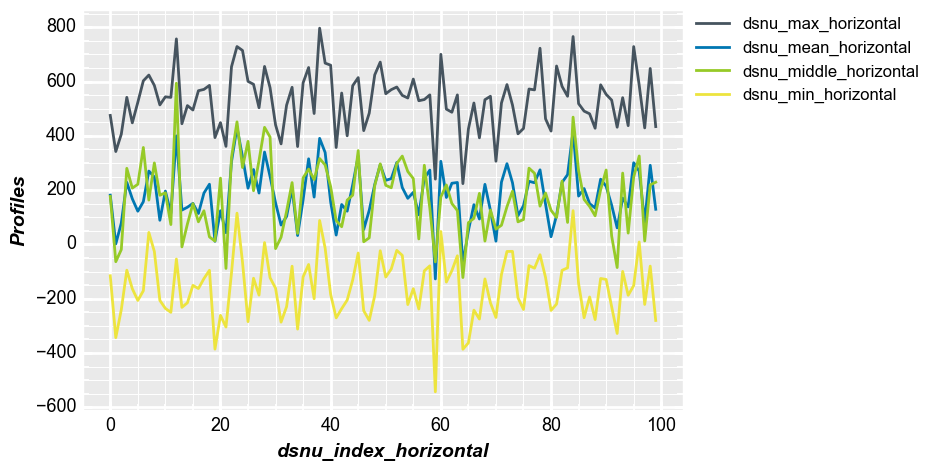

In [122]:
fcp.plot(df=emva_data, x='dsnu_index_horizontal',
         y=['dsnu_max_horizontal','dsnu_mean_horizontal','dsnu_middle_horizontal','dsnu_min_horizontal'],
         ax_size=[600,400], grid_minor=True, markers=False, line_width=2, label_y='Profiles')

###### Vertical Profile

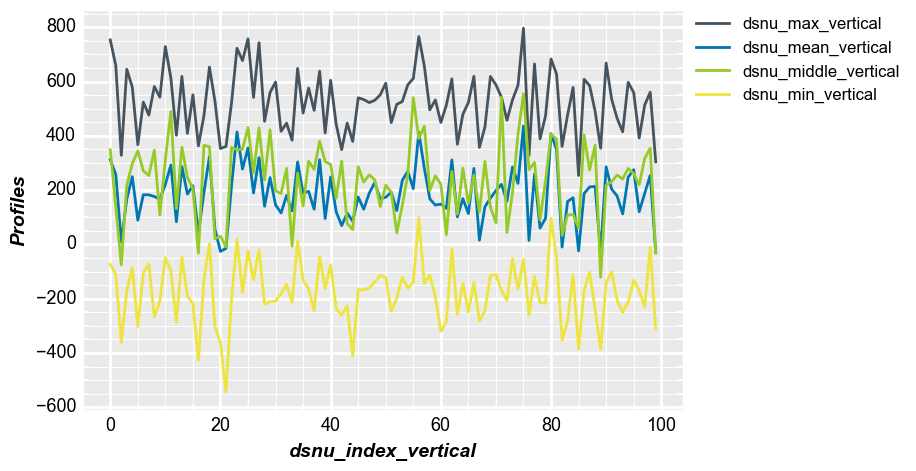

In [123]:
fcp.plot(df=emva_data, x='dsnu_index_vertical',
         y=['dsnu_max_vertical','dsnu_mean_vertical','dsnu_middle_vertical','dsnu_min_vertical'],
         ax_size=[600,400], grid_minor=True, markers=False, line_width=2, label_y='Profiles')

#### Responsivity

~~~ python
"""
calculate responsivity, emva defines this in units DN/photons,
but could u_p could be replaced with lux/uW/cm^2/etc.
EMVA 4.0: Eq. 49

Keyword Arguments:
    u_p (np.array): array of photons
    u_y (np.array): array of signal - dark, u_y should be u_y - u_ydark
    sig2_y (np.array): array of temporal noise values,
                     should be sig2_y - sig2_ydark
Returns:
    temp (dict): Responsivity (float): Responsivity [DN/Photon]
                 Responsivity Offset (float): offset of fit line
                 Responsivity fit [DN] (np.array): responsivity fit line
"""
~~~

##### Calc

In [124]:
# required inputs
u_p = emva_data['Irradiation [Photons/Pixel]']
u_y = emva_data['Signal - Dark [DN]']
sig2_y = emva_data['Total Temp Noise - Total Dark Temp Noise [DN^2]']

# calculate
resp = emva.responsivity(u_p=u_p,
                         u_y=u_y,
                         sig2_y=sig2_y)

emva_data['Responsivity Fit [DN]'] = resp['responsivity_fit']
summ['Responsivity [DN/photon]'] = resp['responsivity']

resp.keys()

dict_keys(['responsivity', 'responsivity_offset', 'responsivity_fit'])

##### Assert

In [125]:
#assert round(resp['responsivity'],0) == 1
print(f'Responsivity [DN/photon] = {round(resp["responsivity"],0)}')

Responsivity [DN/photon] = 1.0


##### Plot

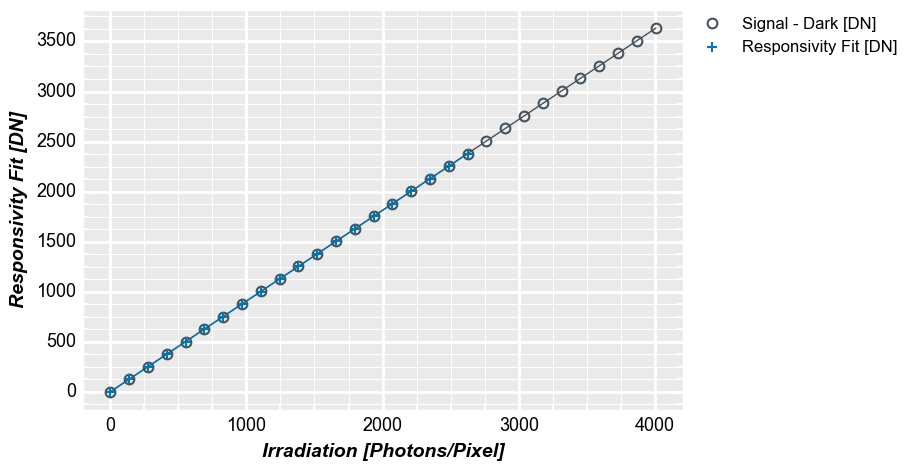

In [126]:
fcp.plot(df=emva_data, y=['Signal - Dark [DN]','Responsivity Fit [DN]'], x=['Irradiation [Photons/Pixel]'],
         ax_size=[600,400], grid_minor=True, label_y = 'Responsivity Fit [DN]')

#### Saturation Capacity

~~~ python
"""
calculate saturation capacity
EMVA 4.0: Eq. 24

Keyword Arguments:
    u_p (np.array): array of photon values
    sig2_y (np.array): array of temporal noise values,
                     should be sig2_y - sig2_ydark
    qe (float): quantum efficiency at wavelength used for dataset

Returns:
    temp (dict): Saturation Capacity [p]
                 Saturation Capacity [e]
"""
~~~

##### Calc

In [152]:
# required inputs
u_p = emva_data['Irradiation [Photons/Pixel]']
sig2_y = emva_data['Total Temp Noise - Total Dark Temp Noise [DN^2]']
qe = 0.9

# calculate
sat = emva.saturation_capacity(u_p=u_p,
                               sig2_y=sig2_y,
                               qe=qe)

summ['Saturation Capacity [e]'] = sat['sat_capacity_e']
summ['Saturation Capacity [p]'] = sat['sat_capacity_p']

sat.keys()

dict_keys(['sat_capacity_p', 'sat_capacity_e'])

##### Assert

In [153]:
round(sat['sat_capacity_e'],0)

3606.0

In [154]:
#assert round(sat['sat_capacity_e'],0) == 3405
print(f'Saturation Capacity [e] = {round(sat["sat_capacity_e"],0)}')

Saturation Capacity [e] = 3606.0


##### Plot

In [133]:
summ[['Saturation Capacity [e]','Saturation Capacity [p]']]

,Saturation Capacity [e],Saturation Capacity [p]
0,3405.368322,4006.315673


#### Sensitivity Threshold

~~~ python
"""
calculate sensitivity threshold
EMVA 4.0: Eq 26 & Eq 27

Keyword Arguments:
    sig2_ydark (float): total temporal noise at dark
    qe (float): quantum efficiency at wavelength used for dataset
    K (float): system gain [DN/e]
    s2_q (float)" quantization noise

Returns:
    temp (dict): Sensitivity Threshold [p]
                 Sensitivity Threshold [e]
"""
~~~

##### Calc

In [137]:
# required inputs
sig2_ydark = data['tot_var_temp'].iloc[0]
qe = 0.9
K = summ['System Gain [DN/e]'].unique()[0]

# calculate
sen = emva.sensitivity_threshold(sig2_ydark=sig2_ydark,
                                 qe=qe,
                                 K=K)

summ['Sensitivity Threshold [e]'] = sen['sensitivity_threshold_e']
summ['Sensitivity Threshold [p]'] = sen['sensitivity_threshold_p']

sen.keys()

dict_keys(['sensitivity_threshold_e', 'sensitivity_threshold_p'])

##### Assert

In [138]:
#assert round(sen['sensitivity_threshold_e'],0) == 24
print(f'Sensitivity Threshold [e] = {round(sen["sensitivity_threshold_e"],0)}')

Sensitivity Threshold [e] = 24.0


##### Plot

In [139]:
summ[['Sensitivity Threshold [e]','Sensitivity Threshold [p]']]

,Sensitivity Threshold [e],Sensitivity Threshold [p]
0,24.262513,26.958347


#### SNR

~~~ python
"""
Calculate SNR using temporal and spatial noise components
EMVA 4.0: Eq. 69

Keyword Arguments:
    dark_img (np.array): average dark image to be used for DSNU
    light_img (np.array): average 50% sat image to be used for PRNU
    dark_ttn_var (float): total temporal noise from dark_img stack
    light_ttn_var (float): total temporal noise from light_img stack
    L (int): size of dark_img and light_img stack used
    u_p (np.array): array of photons
    s2_d (float): dark temporal noise [e]
    K (float): system gain
    qe (float): quantum efficiency
    s2_q (float): quantization noise

Returns:
    temp (dict): SNR [dB]
                 SNR [ratio]
"""
~~~

##### Calc

In [141]:
# required inputs
dark_img = stats.avg_img_stack(images[0])
light_img = stats.avg_img_stack(images[len(images)//2])
dark_ttn_var = np.mean(stats.tot_var_img_stack(images[0]))
light_ttn_var = np.mean(stats.tot_var_img_stack(images[len(images)//2]))
L = n_images
u_p = emva_data['Irradiation [Photons/Pixel]']
s2_d = summ['Dark Noise [e]'].unique()[0]
K = summ['System Gain [DN/e]'].unique()[0]
qe = 0.9

# calculate
snr = emva.snr(dark_img=dark_img,
               light_img=light_img,
               dark_ttn_var=dark_ttn_var,
               light_ttn_var=light_ttn_var,
               L=L,
               u_p=u_p,
               s2_d=s2_d,
               K=K,
               qe=qe)

emva_data['SNR [dB]'] = snr['snr_dB']
emva_data['SNR [ratio]'] = snr['snr_ratio']

snr.keys()

dict_keys(['snr_dB', 'snr_ratio'])

##### Assert

In [142]:
print(f'Mean SNR [ratio] = {round(snr["snr_ratio"].mean(),0)}')
#assert round(snr['snr_ratio'].mean(),0) == 11

Mean SNR [ratio] = 7.0


##### Plot

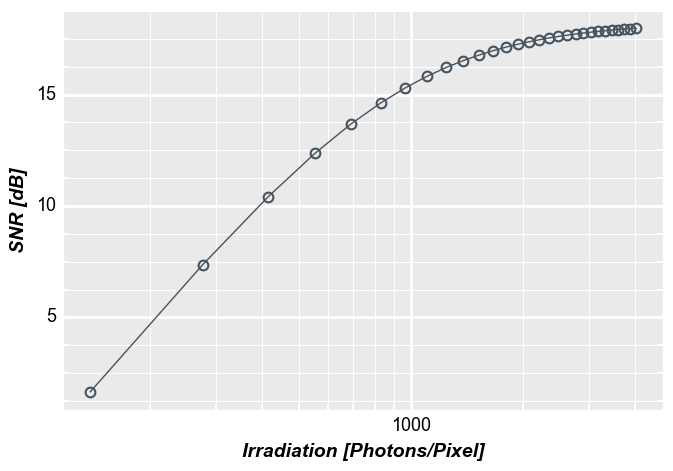

In [143]:
fcp.plot(df=emva_data[1:], y=['SNR [dB]'], x=['Irradiation [Photons/Pixel]'],
         ax_size=[600,400], grid_minor=True, ax_scale='logx')

#### SNR Stack

~~~ python
"""
Calculate SNR using temporal and spatial noise components from a stack
of images
EMVA 4.0: Eq. 69

Keyword Arguments:
    dark_stack (np.array): stack of dark images for DSNU calc
    light_stack (np.array): stack of light images for PRNU calc
    u_p (np.array): array of photons
    s2_d (float): dark temporal noise [e]
    K (float): system gain
    qe (float): quantum efficiency
    s2_q (float): quantization noise

Returns:
    temp (dict): SNR [dB]
                 SNR [ratio]
"""
~~~

##### Calc

In [ ]:
# required inputs
# required inputs
dark_stack = images[0]
light_stack = images[len(images)//2]
u_p = emva_data['Irradiation [Photons/Pixel]']
s2_d = summ['Dark Noise [e]'].unique()[0]
K = summ['System Gain [DN/e]'].unique()[0]
qe = 0.85
# calculate
snr = emva.snr_stack(dark_stack=dark_stack,
                     light_stack=light_stack,
                     u_p=u_p,
                     s2_d=s2_d,
                     K=K,
                     qe=qe)

emva_data['SNR [dB]'] = snr['snr_dB']
emva_data['SNR [ratio]'] = snr['snr_ratio']

snr.keys()

##### Assert

In [ ]:
print(f'Mean SNR [ratio] = {round(snr["snr_ratio"].mean(),0)}')
#assert round(snr['snr_ratio'].mean(),0) == 11

##### Plot

In [ ]:
fcp.plot(df=emva_data[1:], y=['SNR [dB]'], x=['Irradiation [Photons/Pixel]'],
         ax_size=[600,400], grid_minor=True, ax_scale='logx')

#### SNR Ideal

~~~ python
"""
calculate ideal snr (shot noise)
EMVA 4.0: Eq. 23

Keyword Arguments:
    u_p (np.array): array of photons

Returns:
    temp (dict): SNR Ideal [dB]
                 SNR Ideal [ratio]
"""
~~~

##### Calc

In [157]:
# required inputs
u_p = emva_data['Irradiation [Photons/Pixel]']

# calculate
snr_ideal = emva.snr_ideal(u_p=u_p)

emva_data['SNR Ideal [dB]'] = snr_ideal['snr_ideal_dB']
emva_data['SNR Ideal [ratio]'] = snr_ideal['snr_ideal_ratio']

snr_ideal.keys()

dict_keys(['snr_ideal_dB', 'snr_ideal_ratio'])

##### Assert

In [158]:
print(f'Mean SNR Ideal [ratio] = {round(snr_ideal["snr_ideal_ratio"].mean(),0)}')
#assert round(snr_ideal['snr_ideal_ratio'].mean(),0) == 43

Mean SNR Ideal [ratio] = 43.0


##### Plot

In [ ]:
fcp.plot(df=emva_data[1:], y=['SNR Ideal [dB]','SNR [dB]'], x=['Irradiation [Photons/Pixel]'],
         ax_size=[600,400], grid_minor=True, ax_scale='logx')

#### SNR Photons

~~~ python
"""
Get number of photons required for a given SNR value
EMVA 4.0: Eq. 25

Keyword Arguments:
    snr_level (float): snr level to get number of photons for
    u_p (np.array): array of photons
    s2_d (float): dark temporal noise [e]
    K (float): system gain
    qe (float): quantum efficiency
    s2_q (float): quantization noise

Returns:
    temp (dict): Irradiance [Photons/Pixel]
"""
~~~

##### Calc

In [164]:
# required inputs
snr_level=10
u_p = emva_data['Irradiation [Photons/Pixel]']
s2_d = summ['Dark Noise [e]'].unique()[0]
K = summ['System Gain [DN/e]'].unique()[0]
qe = 0.9
# calculate
snr_p = emva.snr_photons(snr_level=snr_level,
                         u_p=u_p,
                         s2_d=s2_d,
                         K=K,
                         qe=qe)

summ[f'Irradiance [Photons/Pixel] @ SNR{snr_level}'] = snr_p['irradiance']

snr_p.keys()

dict_keys(['irradiance'])

##### Assert

In [165]:
snr_p['irradiance']

133.1661202934454

##### Plot

In [166]:
summ[[f'Irradiance [Photons/Pixel] @ SNR{snr_level}']]

,Irradiance [Photons/Pixel] @ SNR10
0,133.16612


#### SNR Theoretical

~~~ python
"""
Calculate SNR based on linear camera model
EMVA 4.0: Eq. 21

Keyword Arguments:
    u_p (np.array): array of photons
    s2_d (float): dark temporal noise [e]
    K (float): system gain
    qe (float): quantum efficiency
    s2_q (float): quantization noise

Returns:
    temp (dict): Theoretical SNR [dB]
                 Theoretical SNR [ratio]
"""
~~~

##### Calc

In [167]:
# required inputs
u_p = emva_data['Irradiation [Photons/Pixel]']
s2_d = summ['Dark Noise [e]'].unique()[0]
K = summ['System Gain [DN/e]'].unique()[0]
qe = 0.9

# calculate
snr_t = emva.snr_theoretical(u_p=u_p,
                             s2_d=s2_d,
                             K=K,
                             qe=qe)

emva_data['SNR Theoretical [dB]'] = snr_t['snr_theoretical_dB']
emva_data['SNR Theoretical[ratio]'] = snr_t['snr_theoretical_ratio']

snr_t.keys()

dict_keys(['snr_theoretical_dB', 'snr_theoretical_ratio'])

##### Assert

In [168]:
#assert round(snr_t['snr_theoretical_ratio'][1:].mean(),0) == 39
print(f'Mean SNR Theoretical [ratio] = {round(snr_t["snr_theoretical_ratio"][1:].mean(),0)}')

Mean SNR Theoretical [ratio] = 41.0


##### Plot

In [ ]:
fcp.plot(df=emva_data[1:], y=['SNR [dB]','SNR Ideal [dB]', 'SNR Theoretical [dB]'], x=['Irradiation [Photons/Pixel]'],
         ax_size=[600,400], grid_minor=True, ax_scale='logx')

#### Spatial Variance

~~~ python
"""
Calculate spatial variance, this function applies hpf
EMVA 4.0: Eq 36

Keyword Arguments:
    img (np.array): 2D array of pixel values
    ttn_var (float): total temporal noise from
                     image stack used to generate img
    L (int): size of image stack used to generate img
    dim (int): dim of hpf, must be odd
    ddof (int, 0): degree of freedom for variance calc

Returns:
    temp (dict): total s2_y
                 row s2_y
                 col s2_y
                 pix s2_y
"""
~~~

##### Calc

In [181]:
# required inputs
ttn_var = data['tot_var_temp'].iloc[0]
img = stats.avg_img_stack(images[0])
L = n_images
dim = 5

# calculate
spat = emva.spatial_variance(img=img,
                             ttn_var=ttn_var,
                             L=n_images,
                             dim=dim)

summ_spatial = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in spat.items()]))
summ = summ.join(summ_spatial)
summ.rename(columns={'total_s2_y': 'Total Spatial Variance [DN]',
                          'row_s2_y': 'Row Spatial Variance [DN]',
                          'col_s2_y': 'Column Spatial Variance [DN]',
                          'pix_s2_y': 'Pixel Spatial Variance [DN]'}, inplace=True)
spat.keys()

dict_keys(['total_s2_y', 'row_s2_y', 'col_s2_y', 'pix_s2_y'])

##### Assert

In [183]:
print(f'Spatial Variance [DN] = {round(np.sqrt(spat["total_s2_y"]),0)}')
#assert round(spat['total_s2_y'],0) == 39

Spatial Variance [DN] = 162.0


##### Plot

In [ ]:
summ[['Total Spatial Variance [DN]','Row Spatial Variance [DN]','Column Spatial Variance [DN]','Pixel Spatial Variance [DN]']]

#### Spectrogram

~~~ python
"""
calcualte horizontal and vertical spectrogram from average image
EMVA 4.0: Eq. 8.6

Keyword Arguments:
    img (np.array): avgerage image to compute spectrogram on
    rotate (bool): if True then vertical spectrogram is returned
    prnu_spect (bool): if True then values are returned as percentage

Returns:
    temp (dict): horizontal data
                 vertical data
                 cycles [periods/pixels]
"""
~~~

##### Calc

In [174]:
# required inputs
img = stats.avg_img_stack(images[0])
prnu_spect = False

# calculate
spectogram = emva.spectrogram(img=img,
                             prnu_spect=prnu_spect)


specto = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in spectogram.items()]))
emva_hist = emva_hist.join(specto)

spectogram.keys()

ValueError: columns overlap but no suffix specified: Index(['dsnu_cycles_horizontal', 'dsnu_power_spectrum_horizontal',
       'dsnu_cycles_vertical', 'dsnu_power_spectrum_vertical'],
      dtype='object')

##### Assert

In [ ]:
#assert round(spectogram['dsnu_power_spectrum_horizontal'].mean(),0) == 6
print(f'Mean of horizontal power spectrum = {round(spectogram["dsnu_power_spectrum_horizontal"].mean(),0)}')

##### Plot

###### Horizontal Profile

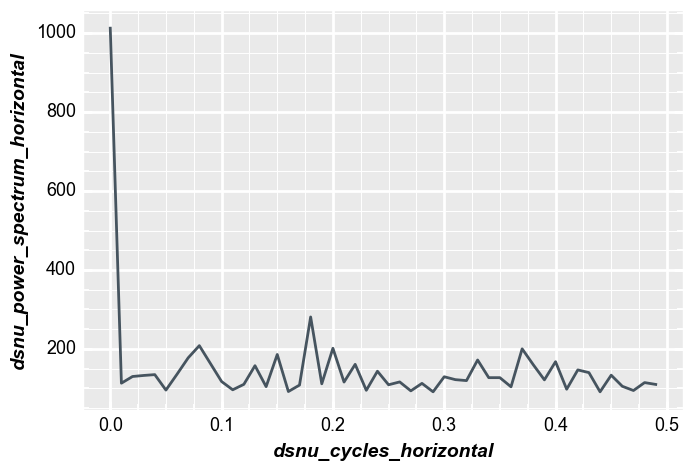

In [175]:
fcp.plot(df=emva_hist, x='dsnu_cycles_horizontal', y=['dsnu_power_spectrum_horizontal'],
         ax_size=[600,400], grid_minor=True, markers=False, line_width=2)

###### Vertical Profile

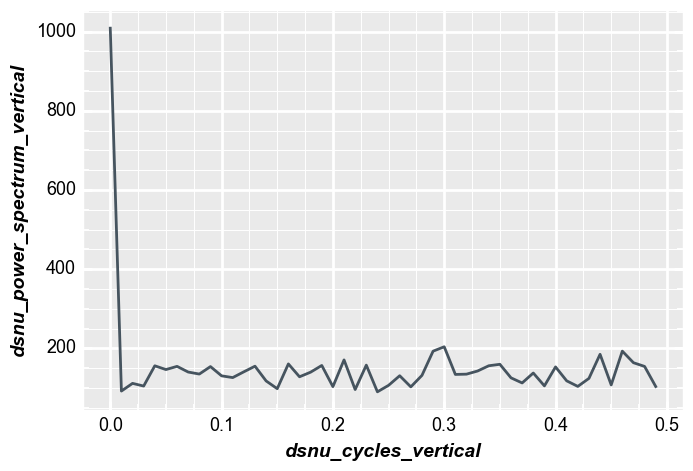

In [176]:
fcp.plot(df=emva_hist, x='dsnu_cycles_vertical', y=['dsnu_power_spectrum_vertical'],
         ax_size=[600,400], grid_minor=True, markers=False, line_width=2)

#### Spectrogram Stack

~~~ python
"""
calcualte horizontal and vertical spectrogram from stack of images
EMVA 4.0: Eq. 8.6

Keyword Arguments:
    img_stack (np.array): stack of images
    prnu_spect (bool): if True then values are returned as percentage

Returns:
    temp (dict): horizontal data
                 vertical data
                 horizontal cycles [periods/pixels]
                 vertical cycles [periods/pixels]
"""
~~~

##### Calc

In [177]:
# required inputs
img_stack=images[0]
prnu_spect = False

# calculate
spectogram = emva.spectrogram_stack(img_stack=img_stack,
                                    prnu_spect=prnu_spect)


#specto = pd.DataFrame(dict([(k,pd.Series(v)) for k,v in spectogram.items()]))
#emva_hist = emva_hist.join(specto)

spectogram.keys()

dict_keys(['dsnu_cycles_horizontal', 'dsnu_power_spectrum_horizontal', 'dsnu_cycles_vertical', 'dsnu_power_spectrum_vertical'])

##### Assert

In [178]:
#assert round(spectogram['dsnu_power_spectrum_horizontal'].mean(),0) == 6
print(f'Mean of horizontal power spectrum = {round(spectogram["dsnu_power_spectrum_horizontal"].mean(),0)}')

Mean of horizontal power spectrum = 150.0


##### Plot

###### Horizontal Profile

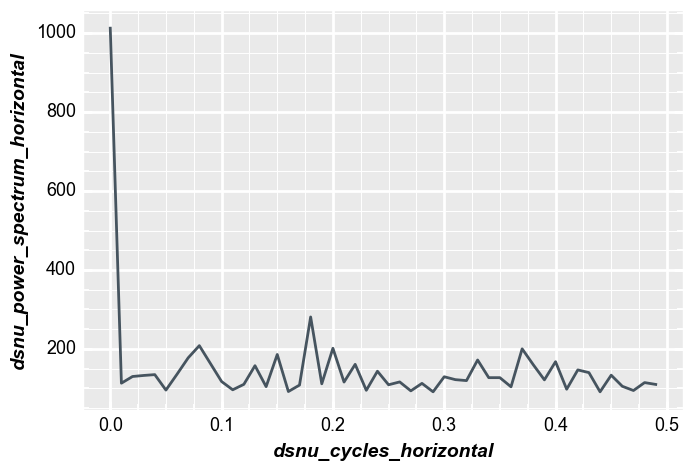

In [179]:
fcp.plot(df=emva_hist, x='dsnu_cycles_horizontal', y=['dsnu_power_spectrum_horizontal'],
         ax_size=[600,400], grid_minor=True, markers=False, line_width=2)

###### Vertical Profile

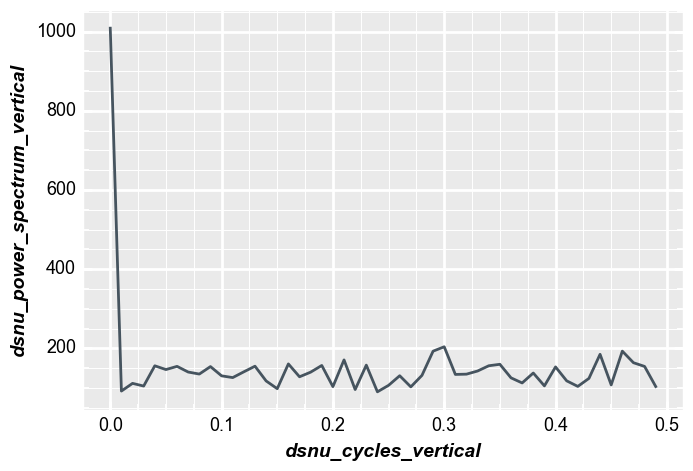

In [180]:
fcp.plot(df=emva_hist, x='dsnu_cycles_vertical', y=['dsnu_power_spectrum_vertical'],
         ax_size=[600,400], grid_minor=True, markers=False, line_width=2)